In [117]:
import pandas as pd
import pandas_flavor as pf
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
# import janitor
# from janitor import remove_columns, rename_column, remove_empty, filter_on, groupby_agg, clean_names

In [118]:
birth_rate_df = pd.read_csv('../data/birth_rate_cl.csv')
birth_rate_df.head(10)

,country,year,birth_rate_per_thousand
0,Afghanistan,1979,48.1
1,Afghanistan,2000,41.2
2,Afghanistan,2009,35.6
3,Albania,1970,32.5
4,Albania,1985,26.2
5,Albania,1995,23.6
6,Albania,2005,12.6
7,Albania,2011,10.1
8,Algeria,1970,43.9
9,Algeria,1985,38.3


In [119]:
birth_rate_df = birth_rate_df.groupby([birth_rate_df['country'], birth_rate_df['year'] // 10 * 10]).agg({'birth_rate_per_thousand': 'mean'}).reset_index()
birth_rate_df

,country,year,birth_rate_per_thousand
0,Afghanistan,1970,48.10
1,Afghanistan,2000,38.40
2,Albania,1970,32.50
3,Albania,1980,26.20
4,Albania,1990,23.60
...,...,...,...
943,Zambia,2000,43.45
944,Zimbabwe,1960,47.00
945,Zimbabwe,1980,39.50
946,Zimbabwe,1990,31.80


In [120]:
fertility_rate_df = pd.read_csv('../data/fertility_rates_cl.csv')
fertility_rate_df.head(10)


,country,total_fertility,mean_age_at_childbearing_,year
0,Afghanistan,8.21,30.0,1970
1,Afghanistan,7.52,30.1,2005
2,Afghanistan,5.11,29.1,2020
3,Albania,5.16,29.7,1970
4,Albania,3.33,28.8,1985
5,Albania,2.86,27.6,1995
6,Albania,1.61,27.7,2005
7,Albania,1.33,28.2,2020
8,Algeria,7.86,30.4,1970
9,Algeria,5.35,31.8,1985


In [121]:

fertility_rate_df = fertility_rate_df.groupby([fertility_rate_df['country'], fertility_rate_df['year'] // 10 * 10]).agg({'total_fertility': 'mean', 'mean_age_at_childbearing_': 'mean'}).reset_index()
fertility_rate_df

,country,year,total_fertility,mean_age_at_childbearing_
0,Afghanistan,1970,8.21,30.0
1,Afghanistan,2000,7.52,30.1
2,Afghanistan,2020,5.11,29.1
3,Albania,1970,5.16,29.7
4,Albania,1980,3.33,28.8
...,...,...,...,...
997,Zimbabwe,1970,6.74,31.2
998,Zimbabwe,1980,5.42,29.5
999,Zimbabwe,1990,3.98,28.3
1000,Zimbabwe,2000,3.80,28.1


In [122]:
gdp_df = (
    pd.read_csv('../data/gdp_le_cont.csv')
    .rename(columns={'Country': 'country', 'Year': 'year'})
)
gdp_df.head(10)

,Unnamed: 0,country,year,Item,GDP_Per_Capita,Continent,Life Expectancy
0,0,Afghanistan,2021,Gross Domestic Product (GDP),372.548875,Asia,61.982
1,1,Afghanistan,2020,Gross Domestic Product (GDP),516.866543,Asia,62.575
2,2,Afghanistan,2019,Gross Domestic Product (GDP),500.522664,Asia,63.565
3,3,Afghanistan,2018,Gross Domestic Product (GDP),502.056771,Asia,63.081
4,4,Afghanistan,2017,Gross Domestic Product (GDP),530.149831,Asia,63.016
5,5,Afghanistan,2016,Gross Domestic Product (GDP),520.252064,Asia,63.136
6,6,Afghanistan,2015,Gross Domestic Product (GDP),554.403216,Asia,62.659
7,7,Afghanistan,2014,Gross Domestic Product (GDP),597.584579,Asia,62.545
8,8,Afghanistan,2013,Gross Domestic Product (GDP),622.100518,Asia,62.417
9,9,Afghanistan,2012,Gross Domestic Product (GDP),628.116539,Asia,61.923


In [123]:
gdp_df = gdp_df.groupby([gdp_df['country'], gdp_df['Life Expectancy'], gdp_df['Continent'], gdp_df['year'] // 10 * 10]).agg({'GDP_Per_Capita': 'mean'}).reset_index()

gdp_df.head(10)

,country,Life Expectancy,Continent,year,GDP_Per_Capita
0,Afghanistan,33.329,Asia,1980,328.896351
1,Afghanistan,33.550,Asia,1980,316.818461
2,Afghanistan,37.418,Asia,1970,161.019274
3,Afghanistan,37.766,Asia,1980,340.062140
4,Afghanistan,37.923,Asia,1970,164.566181
5,Afghanistan,38.187,Asia,1980,342.483252
6,Afghanistan,38.444,Asia,1970,146.003034
7,Afghanistan,39.003,Asia,1970,147.099044
8,Afghanistan,39.086,Asia,1970,279.582989
9,Afghanistan,39.396,Asia,1980,317.835797


In [124]:
merged_df = gdp_df.merge(birth_rate_df, on=['year', 'country'], how='left').merge(fertility_rate_df, on=['year', 'country'], how='left')
continents = pd.read_csv("../data/continents.csv")
df = pd.merge(merged_df, continents, on='Country', how='inner')

def interpolate_by_group(group):
    return group.interpolate(method='linear').reset_index(drop=True)

drop_na_df = merged_df.dropna()
forward_fill_df = merged_df.fillna(method='ffill') 
linear_df = merged_df.apply(interpolate_by_group).reset_index(level=0, drop=True)
# polynomial = merged_df.groupby('country').interpolate(method='polynomial', order=2)
drop_na_df = drop_na_df.rename(columns={'Life Expectancy': 'life exp', 'Continent': 'cont', 'birth_rate_per_thousand': 'birth_rate_cap' })
print(f'dropping null values: \n {drop_na_df.head(20).to_string(index=False)}')
drop_na_df.to_csv("../data/gdp_fert_birth.csv")
# print(f'no fill: \n {merged_df.head(20).to_string(index=False)}')
# print(f'forward fill: \n{forward_fill.head(20).to_string(index=False)}')
# print(f'linear fill:\n {linear.head(20).to_string(index=False)}')
# print(f'polynomial fill order 2:\n {polynomial.head(30)}')

dropping null values: 
     country  life exp cont  year  GDP_Per_Capita  birth_rate_cap  total_fertility  mean_age_at_childbearing_
Afghanistan    37.418 Asia  1970      161.019274            48.1             8.21                       30.0
Afghanistan    37.923 Asia  1970      164.566181            48.1             8.21                       30.0
Afghanistan    38.444 Asia  1970      146.003034            48.1             8.21                       30.0
Afghanistan    39.003 Asia  1970      147.099044            48.1             8.21                       30.0
Afghanistan    39.086 Asia  1970      279.582989            48.1             8.21                       30.0
Afghanistan    39.550 Asia  1970      173.694213            48.1             8.21                       30.0
Afghanistan    40.100 Asia  1970      190.810221            48.1             8.21                       30.0
Afghanistan    40.271 Asia  1970      249.091754            48.1             8.21                       

In [125]:
# Calculate GDP change

# Grouping by country means subsequent operations will be performed for each country individually
# GDP.apply() means we are taking the value for GDP_Per_Capita and using it for each country as x in our lambda function, 
# which takes the first and last values using integer location, since we are grouping by GDP we can use iloc[0] to grab first value and subtracting
# that from the last value iloc[-1]

gdp_change = drop_na_df.groupby('country')['GDP_Per_Capita'].apply(lambda x: x.iloc[-1] - x.iloc[0])

# Top 5 countries with greatest positive change
top_positive = gdp_change.nlargest(5).index.tolist()

# Top 5 countries with greatest negative change
top_negative = gdp_change.nsmallest(5).index.tolist()

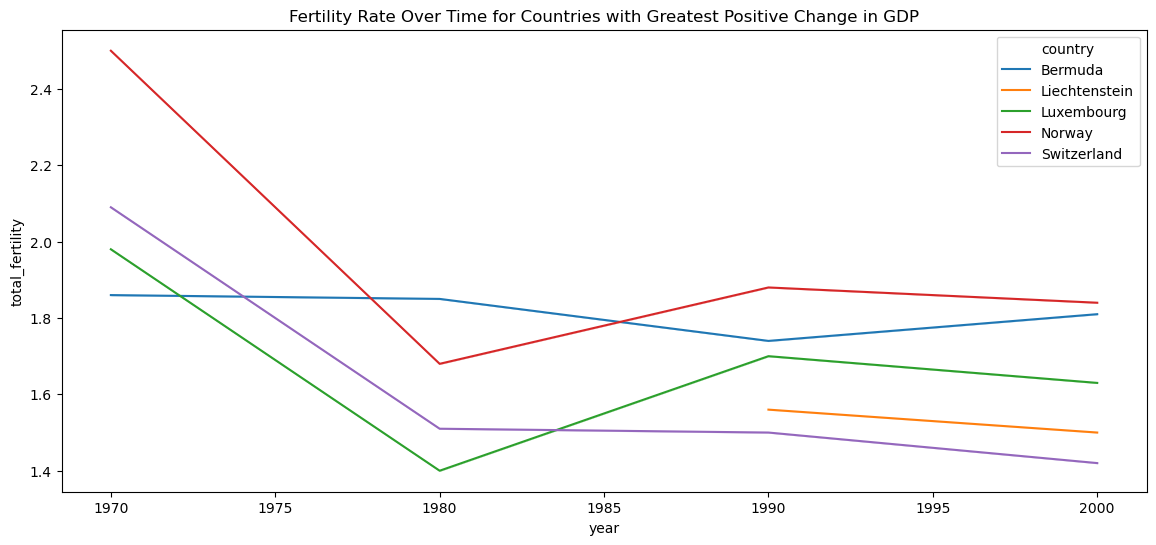

ValueError: Could not interpret value `birth_rate_per_thousand` for parameter `y`

<Figure size 1400x600 with 0 Axes>

In [126]:
# Filter the DataFrame for top countries
positive_df = drop_na_df[drop_na_df['country'].isin(top_positive)]
negative_df = drop_na_df[drop_na_df['country'].isin(top_negative)]

# Plotting fertility rate for countries with greatest positive GDP change
plt.figure(figsize=(14, 6))
sns.lineplot(data=positive_df, x='year', y='total_fertility', hue='country')
plt.title("Fertility Rate Over Time for Countries with Greatest Positive Change in GDP")
plt.show()

# Plotting birth rate for countries with greatest positive GDP change
plt.figure(figsize=(14, 6))
sns.lineplot(data=positive_df, x='year', y='birth_rate_per_thousand', hue='country')
plt.title("Birth Rate Over Time for Countries with Greatest Positive Change in GDP")
plt.show()

# Plotting fertility rate for countries with greatest negative GDP change
plt.figure(figsize=(14, 6))
sns.lineplot(data=negative_df, x='year', y='total_fertility', hue='country')
plt.title("Fertility Rate Over Time for Countries with Greatest Negative Change in GDP")
plt.show()

# Plotting birth rate for countries with greatest negative GDP change
plt.figure(figsize=(14, 6))
sns.lineplot(data=negative_df, x='year', y='birth_rate_per_thousand', hue='country')
plt.title("Birth Rate Over Time for Countries with Greatest Negative Change in GDP")
plt.show()

# Plotting age at childbearing for countries with greatest negative GDP change
plt.figure(figsize=(14, 6))
sns.lineplot(data=positive_df, x='year', y='mean_age_at_childbearing_', hue='country')
plt.title("Childbearing Age Over Time for Countries with Greatest Positive Change in GDP")
plt.show()

# Plotting age at childbearing for countries with greatest negative GDP change
plt.figure(figsize=(14, 6))
sns.lineplot(data=negative_df, x='year', y='mean_age_at_childbearing_', hue='country')
plt.title("Childbearing Age Over Time for Countries with Greatest Negative Change in GDP")
plt.show()